#Treinar a rede GAN para gerar novos digitos

In [1]:
import os

from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

import time

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [3]:
z_dim = 100
adam = Adam(learning_rate=0.0002, beta_1=0.5)

In [4]:
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [5]:
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [6]:
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [7]:
def imprimir_perda(perdas):
    d_loss = [v[0] for v in perdas["D"]]
    g_loss = [v[0] for v in perdas["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Perda discriminador")
    plt.plot(g_loss, label="Perda gerador")
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.savefig("/content/drive/MyDrive/Digitos_GAN/Funcao_Perda.png")
    plt.show()  

In [8]:
def imprimir_geracao(n_ex=10, dim=(1, 10), figsize=(12, 2), iteracao=1):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/Digitos_GAN/geracao_%d.png" %iteracao)
    plt.show()

In [9]:
funcao_perda = {"D":[], "G":[]}

def treinar_rede(epocas=1, tamanho_lote=128):
    batchCount = int(X_train.shape[0] / tamanho_lote)
    print('Épocas:', epocas)
    print('Tamanho do Lote:', tamanho_lote)
    print('Lotes por época:', batchCount)
    
    for e in tqdm_notebook(range(1, epocas+1)):
      print("#"*10, "Época %d" %e, "#"*10)
      for _ in range(batchCount):
          image_batch = X_train[np.random.randint(0, X_train.shape[0], size=tamanho_lote)]
          noise = np.random.normal(0, 1, size=(tamanho_lote, z_dim))
          
          generated_images = g.predict(noise)
          X = np.concatenate((image_batch, generated_images))
          y = np.zeros(2*tamanho_lote)
          y[:tamanho_lote] = 0.9

          d.trainable = True
          d_loss = d.train_on_batch(X, y)

          noise = np.random.normal(0, 1, size=(tamanho_lote, z_dim))
          y2 = np.ones(tamanho_lote)
          d.trainable = False
          g_loss = gan.train_on_batch(noise, y2)

      funcao_perda["D"].append(d_loss)
      funcao_perda["G"].append(g_loss)

      imprimir_geracao(iteracao=e)

    imprimir_perda(funcao_perda)

Épocas: 100
Tamanho do Lote: 128
Lotes por época: 468


<ipython-input-9-e0da95d61bf1>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(1, epocas+1)):


  0%|          | 0/100 [00:00<?, ?it/s]

--------------- Época 1 ---------------
1/1 [==============================] - 0s 60ms/step


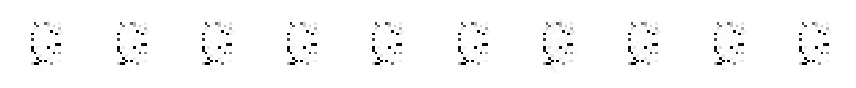

1/1 [==============================] - 0s 19ms/step


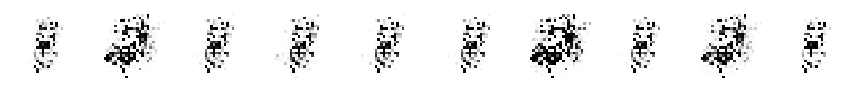

1/1 [==============================] - 0s 21ms/step


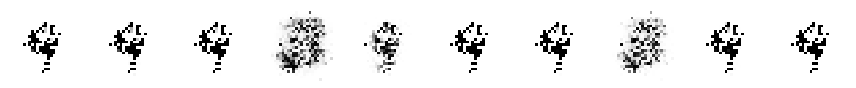

1/1 [==============================] - 0s 19ms/step


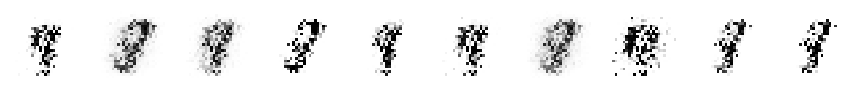

1/1 [==============================] - 0s 22ms/step


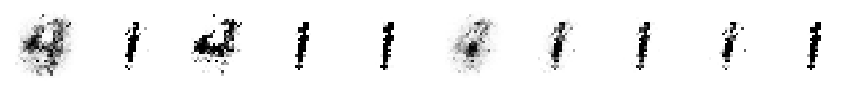

1/1 [==============================] - 0s 19ms/step


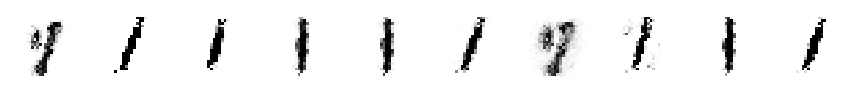

1/1 [==============================] - 0s 19ms/step


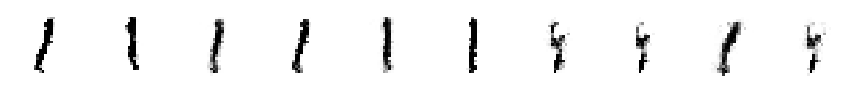

1/1 [==============================] - 0s 19ms/step


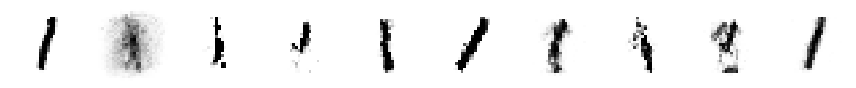

1/1 [==============================] - 0s 19ms/step


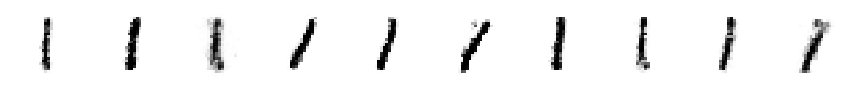

1/1 [==============================] - 0s 19ms/step


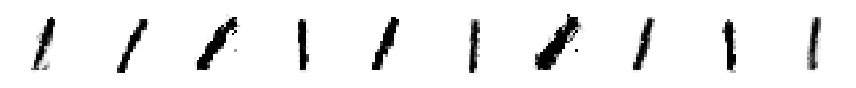

1/1 [==============================] - 0s 23ms/step


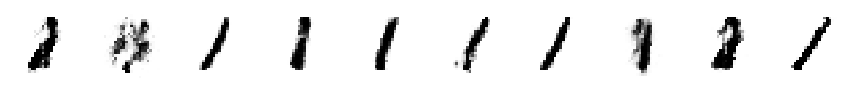

1/1 [==============================] - 0s 18ms/step


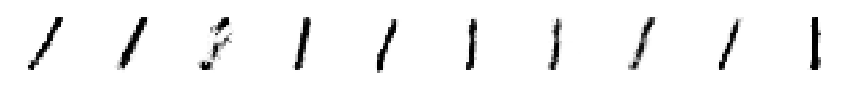

1/1 [==============================] - 0s 21ms/step


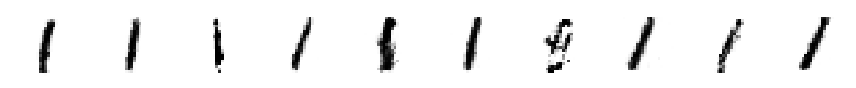

4/4 [==============================] - 0s 8ms/step


KeyboardInterrupt: ignored

In [10]:
#treinar_rede(epocas=100, tamanho_lote=128)
treinar_rede(epocas=100, tamanho_lote=1000)

In [ ]:
imprimir_perda(funcao_perda)

In [ ]:
g.save('gerador.h5')
d.save('discriminador.h5')

In [ ]:
def gerar_digito(n_ex=1, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    imagem_gerada = g.predict(noise)
    imagem_gerada = imagem_gerada.reshape(28, 28)

    plt.imshow(imagem_gerada, interpolation='nearest', cmap='gray_r')
    plt.figure(figsize=figsize)
    plt.tight_layout()
    plt.show()

In [ ]:
gerar_digito()